<a href="https://colab.research.google.com/github/NatalyaEvans/ETNP_stoich/blob/main/pyompa_scripts/ETNP_pyompa_for_WOD_full_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Perform an OMP on the ETNP ODZ data from the WOD18 to determine variations in the stoichiometry of anaerobic remineralization

Reference for Evans et al: https://aslopubs.onlinelibrary.wiley.com/doi/abs/10.1002/lno.11412
Add other references

This version finds the mean value around a region of water mass endmembers using remineralization.

To do:
Set up a better sensitivity function to do this
Remove the weighting sensitivity
Put the sensitivity code into a new file that you can load in with github

Comment the shit out of this

Install pyompa and gsw

In [ ]:
!pip install pyompa==0.4.2.0
!pip install gsw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyompa: filename=pyompa-0.4.2.0-py3-none-any.whl size=27944 sha256=7ad232346a47ffd1c0bb60dfdb8387f29f2e00888f32148a914e8ed44a2d52b9
  Stored in directory: /root/.cache/pip/wheels/ee/bf/52/4e3078948c0fc6eacfffc76536a754087fb12697781430ecec
Successfully built pyompa
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.4 MB 2.2 MB/s 


Mount the google drive folder


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/pyompa/ETNP WOD pyompa"
!ls

/content/drive/MyDrive/pyompa/ETNP WOD pyompa
'Copy of etnp_pyompa_for_wod_with_sensitivity.ipynb'
 ETNP_df_ompasoln.csv
 ETNP_pyompa_for_WOD.ipynb
 ETNP_pyompa_for_WOD_with_sensitivity.ipynb
 ETNP_pyompa_ref_values.csv
 param_weightings_sensitivity
 pyompa_plotter_reox.m
 sampled_weightings.json
 WOD_cleaned.csv
 WOD_ETNP_pyompa_2.csv
 WOD_ETNP_pyompa_2_reduced.csv



Load the input data

In [ ]:
import scipy.io
from scipy.io import loadmat
import pandas as pd
import numpy as np

# csv style
inp_df = pd.read_csv("WOD_ETNP_pyompa_2.csv")

inp_df = inp_df.rename(columns={'Potential Density Anomaly ~$s~#~_0 [kg/m~^3]': 'pdens','Absolute Salinity S~_A [g/kg]': 'SA', 'Conservative Temperature ~$Q~# [degC]': 'CT',
                                'Nitrate [~$m~#mol/kg]': 'Nitrate', 'Phosphate [~$m~#mol/kg]': 'Phosphate', 'Silicate [~$m~#mol/kg]': 'Silicate', 'tCO~_2 [mmol/l]': 'tCO2'})

#Filter the data frame to density ranges used for intermedite waters
data_df = pd.DataFrame(
   inp_df[(inp_df["pdens"] >= 26.4)
              & (inp_df["pdens"] <= 27.3)])
data_df.size


232024

In [ ]:
data_df.columns
data_df["tCO2"]=1000*data_df["tCO2"]*(1000/(1000+data_df["pdens"]))
data_df["Nstar"]=data_df["Nitrate"]-16*data_df["Phosphate"]
data_df=data_df.drop(data_df[data_df["Nstar"]>-5.75].index)
data_df=data_df.drop(data_df[data_df["Nstar"]+2.25*data_df["Phosphate"]+0.5275>0].index)
data_df=data_df.drop(data_df[data_df["Longitude [degrees_east]"]<-115].index)
data_df.to_csv("WOD_ETNP_pyompa_2_reduced.csv")
data_df.size

64978

In [ ]:
data_df = pd.read_csv("WOD_ETNP_pyompa_2_reduced.csv")

Define the end-members. Column headers here have to match those of the observations pandas

In [ ]:
# Bograd 2019 style
endmembers_df_read = pd.read_csv("ETNP_pyompa_ref_values.csv")


In [ ]:
endmembers_df_read.head()

Params      CT     SA  Phosphate  Nitrate  Silicate  tCO2  pdens  \
0   13CW  13.410  34.95       2.33    29.99     23.50  2235  26.29   
1  NEPIW   9.470  34.78       2.65    35.60     33.86  2270  26.74   
2   AAIW   5.530  34.70       3.13    43.21     83.68  2323  27.25   
3  uPSUW   7.765  32.96       1.13    10.07     11.40  2235  25.60   
4  13CW2  13.410  34.95       2.31    31.79     23.98  2281  26.29   

                                               Notes  
0  Adjusted to a more centered point in intersection  
1                                                NaN  
2  Shifted to on the intersection, rather than th...  
3                                                NaN  
4                                                NaN

Remove the non-water types from the endmembers

In [ ]:
endmembers_df = endmembers_df_read.iloc[[0,1,2]] # use uPSUW or no fourth

endmembers_df.head()

Params     CT     SA  Phosphate  Nitrate  Silicate  tCO2  pdens  \
0   13CW  13.41  34.95       2.33    29.99     23.50  2235  26.29   
1  NEPIW   9.47  34.78       2.65    35.60     33.86  2270  26.74   
2   AAIW   5.53  34.70       3.13    43.21     83.68  2323  27.25   

                                               Notes  
0  Adjusted to a more centered point in intersection  
1                                                NaN  
2  Shifted to on the intersection, rather than th...

Define the pyompa parameters to replicate the matlab OMP analysis, and run the analysis

In [ ]:
import pyompa
from pyompa.endmemberpenaltyfunc import GeneralPenaltyFunc

convertedparamgroups = [
    pyompa.ConvertedParamGroup(
        groupname="aerobic_remin",
        conversion_ratios=[{"Phosphate": 1.0, "Nitrate": 14, "Silicate": 12, "tCO2": 98},
        {"Phosphate": 1.0, "Nitrate": 17, "Silicate": 48, "tCO2": 118}],
        always_positive=False 
        ),pyompa.ConvertedParamGroup(
        groupname="anaerobic_remin",
        conversion_ratios=[
        {"Phosphate": 1.0, "Nitrate": -40, "Silicate": 15, "tCO2": 98},
        {"Phosphate": 1.0, "Nitrate": -65, "Silicate": 48, "tCO2":118}
        ],
        always_positive=True 
        )
]

usage_penalty = { 
    "AAIW": GeneralPenaltyFunc(
        spec={
            'pdens':
            # {'type':'exp_density_default', 'lowerbound':26.7}})
            {'type':'exp_other',"alpha":0.03, "beta":50, 'lowerbound':26.7}})}

paramweightings = {
    "CT": 12.0,
    "SA": 8.0,
    "Phosphate": 6.0,
    "Nitrate": 4.0,
    "tCO2": 4.0,
    "Silicate": 2.0
}

settings = {
    "param_names": ["CT", "SA",
                    "Phosphate", "Nitrate",
                    "Silicate"
                    ,"tCO2"
                    ],
    "param_weightings": paramweightings,
    "convertedparam_groups": convertedparamgroups,
    #setting sumtooneconstraint to False replicates the behavior of the
    # MATLAB OMP implementation, which does not enforce mass conservation.
    # By default, sumtooneconstraint is True in pyompa.
    "sumtooneconstraint": True,
    #standardize_by_watertypes=True replicates the normalization behavior
    # of the MATLAB OMP implementation. By default, this is False.
    "standardize_by_watertypes": False}

#Run the analysis, replicating the MATLAB OMP analysis
ETNP_df_ompasoln = pyompa.OMPAProblem(
  obs_df = data_df,
  endmembername_to_usagepenaltyfunc=usage_penalty,
  **settings).solve(
      endmembers_df,
      endmember_name_column="Params")
  
# ** notation uses a python dictionary and maps the keys in that dict to the parameter names, shorthand parameter specs nto a dictionary

Dropping 6 rows that have NA values in the observations
Adding penalty for AAIW
Endmember-idx mapping is
 OrderedDict([('13CW', [0]), ('NEPIW', [1]), ('AAIW', [2])])
params to use: ['CT', 'SA', 'Phosphate', 'Nitrate', 'Silicate', 'tCO2']
param weighting: [12.  8.  6.  4.  2.  4.]
Matrix A:
Trying convertedvariable sign constraint: [1 1 1 1]
On example 0 to 1220 out of 1220
status: optimal
optimal value 47499.8199427904
Original weighted sum squares: 47499.722722814666
Post fix weighted sum squared: 47500.51053350982
Trying convertedvariable sign constraint: [-1 -1  1  1]
On example 0 to 1220 out of 1220
status: optimal
optimal value 153595.2774665839
Original weighted sum squares: 153594.97496941237
Post fix weighted sum squared: 153595.1601792468
On example 0 to 1220 out of 1220
status: optimal
optimal value 18470.820781074537
Original weighted sum squares: 18470.685525267363
Post fix weighted sum squared: 18470.905577328624
objective: 18470.905577328624



Load in plotting tools

In [ ]:
from matplotlib import pyplot as plt
from pyompa import (plot_ompasoln_endmember_fractions,                       
                    plot_ompasoln_residuals,                                 
                    plot_ompasoln_endmember_usagepenalties)

Plot results

Water mass fractions and deltaP


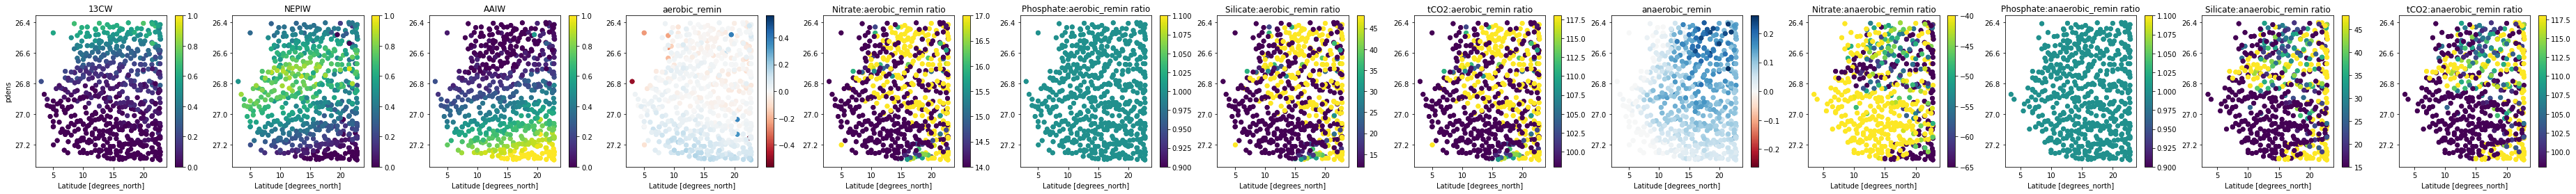

In [ ]:
# xaxis_colname="Longitude [degrees_east]"
xaxis_colname="Latitude [degrees_north]"

yaxis_colname = "pdens"
print("Water mass fractions and deltaP")
plot_ompasoln_endmember_fractions(ompa_soln=ETNP_df_ompasoln,
                                  xaxis_colname=xaxis_colname,
                                  yaxis_colname=yaxis_colname)


Plot residuals

Residuals


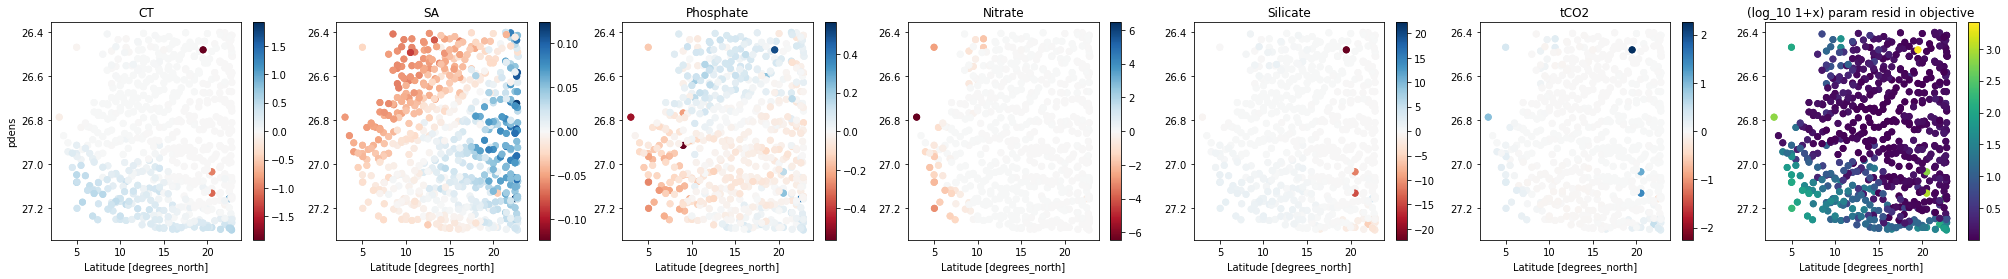

In [ ]:
print("Residuals")
plot_ompasoln_residuals(ompa_soln=ETNP_df_ompasoln,
                        xaxis_colname=xaxis_colname,
                        yaxis_colname=yaxis_colname)

Output the pyompa sol'n




In [ ]:
from collections import OrderedDict

# ORIG_COLS_TO_INCLUDE = ["lat", "long", "pdens", "pressure", "nitrate", "oxygen", "phosphate",'conservative_temp', 'absolute_salinity']
ORIG_COLS_TO_INCLUDE = list(inp_df.columns.values)
ETNP_df_ompasoln.export_to_csv(
    csv_output_name="ETNP_df_ompasoln.csv",
    orig_cols_to_include=ORIG_COLS_TO_INCLUDE)


writing to ETNP_df_ompasoln.csv


Starting sensitivity analysis
Don't forget to ask Avanti how to put this file into my github for the paper!

In [ ]:
#Install gp15wmascripts
!pip uninstall -y gp15wma
%cd /content/
!rm -rf gp15wmascripts
!git clone https://github.com/nitrogenlab/gp15wmascripts
%cd /content/gp15wmascripts
!git checkout main
!git log -1
!pip install .
%cd /content/

%reload_ext autoreload
%autoreload 2
from importlib import reload
import gp15wma
reload(gp15wma)

/content
Cloning into 'gp15wmascripts'...
remote: Enumerating objects: 248, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 248 (delta 13), reused 3 (delta 3), pack-reused 226
Receiving objects: 100% (248/248), 16.42 MiB | 18.71 MiB/s, done.
Resolving deltas: 100% (137/137), done.
/content/gp15wmascripts
Already on 'main'
Your branch is up to date with 'origin/main'.
commit 0f8be9e53d4dfdb510bd26abfe98a12fce38a942 (HEAD -> main, origin/main, origin/HEAD)
Author: rml54 <45828236+rml54@users.noreply.github.com>
Date:   Mon Apr 18 17:02:17 2022 -0400

    Update funcdump.py
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/gp15wmascripts
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new beha

<module 'gp15wma' from '/usr/local/lib/python3.7/dist-packages/gp15wma/__init__.py'>

In [ ]:
from gp15wma.sensitivity import BaseSensitivityAnalysis, OmpaArguments

Sensitivity with regards to weightings

In [ ]:
#Prepare the varying OMPA arguments

import json

rng = np.random.RandomState(1234) #instantiate random number generator with fixed seed
num_samples = 20
base_weighting = paramweightings

#sample varying parameter weightings
sampled_weightings = []
for i in range(num_samples):
    rand_weighting = dict([
        (key, rng.uniform(value*0.8, value*1.2))
        for key,value in base_weighting.items()
    ])
    sampled_weightings.append(rand_weighting)

#write out the various sampled weightings
open("sampled_weightings.json", "w").write(
    json.dumps(sampled_weightings, indent=4))

varying_arguments_list = [OmpaArguments(
        constructor_arguments={"param_weightings": rand_weighting},
        solve_arguments={}) for weighting in sampled_weightings]

ETNP_weighting_sens_analysis = BaseSensitivityAnalysis(
    static_ompa_arguments = OmpaArguments(
        constructor_arguments={
          "obs_df": ETNP_df_ompasoln.obs_df,
          "endmembername_to_usagepenaltyfunc": usage_penalty,
          "param_names": ETNP_df_ompasoln.param_names,
          "convertedparam_groups": convertedparamgroups
          },
        solve_arguments={
            "endmember_df": endmembers_df,
            "endmember_name_column": "Params",
            "batch_size": 100
        }
    ))

!mkdir param_weightings_sensitivity
ompa_solns = ETNP_weighting_sens_analysis.run(
    varying_arguments_list = varying_arguments_list,
    outdir="param_weightings_sensitivity",
    export_settings={"orig_cols_to_include":ORIG_COLS_TO_INCLUDE})


On varying argument 0 out of 20
varying arguments: OMPAArguments(constructor_arguments={'param_weightings': {'CT': 13.819531975270444, 'SA': 7.208370416148897, 'Phosphate': 5.635221102886431, 'Nitrate': 3.492141970528494, 'tCO2': 4.642873682193587, 'Silicate': 2.165222530537438}}, solve_arguments={})
Adding penalty for AAIW
Endmember-idx mapping is
 OrderedDict([('13CW', [0]), ('NEPIW', [1]), ('AAIW', [2])])
params to use: ['CT', 'SA', 'Phosphate', 'Nitrate', 'Silicate', 'tCO2']
param weighting: [13.81953198  7.20837042  5.6352211   3.49214197  2.16522253  4.64287368]
Matrix A:
Trying convertedvariable sign constraint: [1 1 1 1]
On example 0 to 100 out of 1220
status: optimal
optimal value 25941.693807280404
Original weighted sum squares: 25941.6935523953
Post fix weighted sum squared: 25941.931847479522
On example 100 to 200 out of 1220
status: optimal
optimal value 941.9504989777962
Original weighted sum squares: 941.9500215605582
Post fix weighted sum squared: 941.9500216294322
On e

In [ ]:
from gp15wma.sensitivity import get_mean_and_stdev_skeletons

mean_skeleton, std_skeleton = get_mean_and_stdev_skeletons(ompa_solns=ompa_solns)

mean


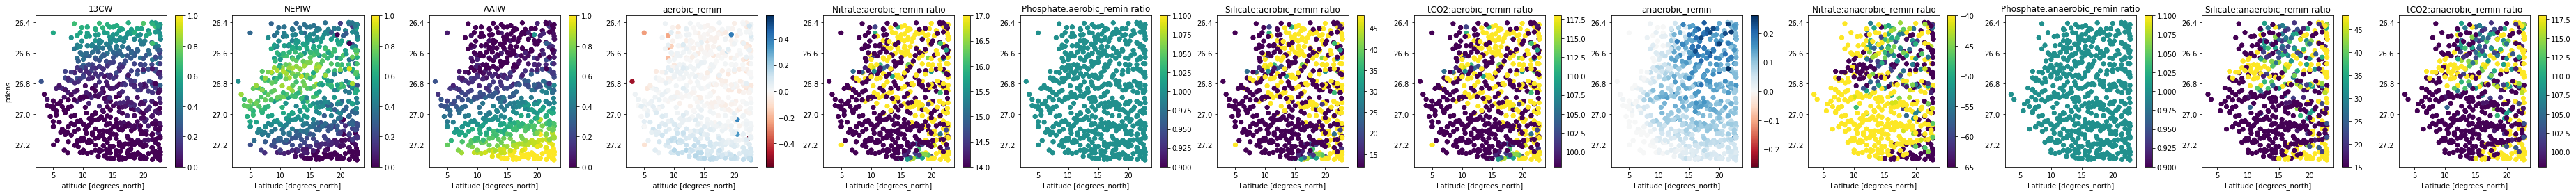

std


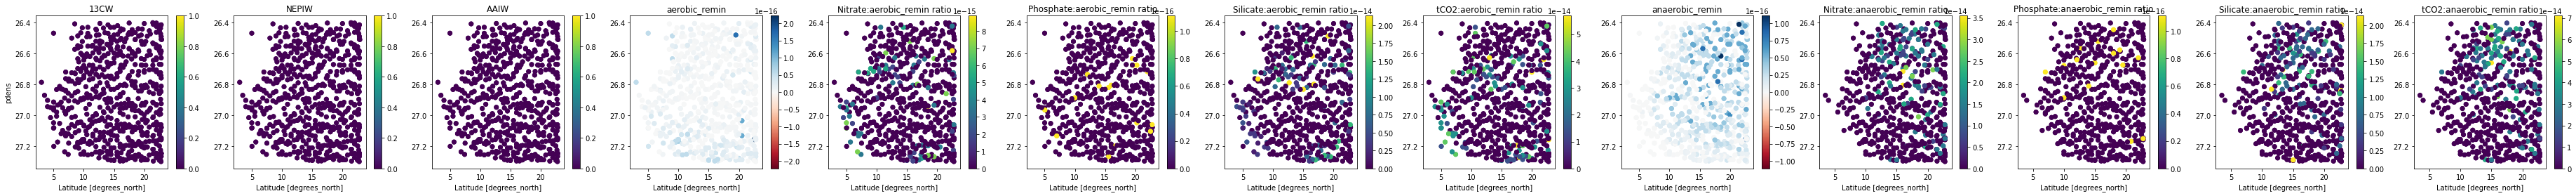

In [ ]:
#plot the solutions
print("mean")
pyompa.plot_ompasoln_endmember_fractions(ompa_soln=mean_skeleton,
                                  xaxis_colname="Latitude [degrees_north]",
                                  yaxis_colname="pdens")
print("std")
pyompa.plot_ompasoln_endmember_fractions(ompa_soln=std_skeleton,
                                  xaxis_colname="Latitude [degrees_north]",
                                  yaxis_colname="pdens")

mean


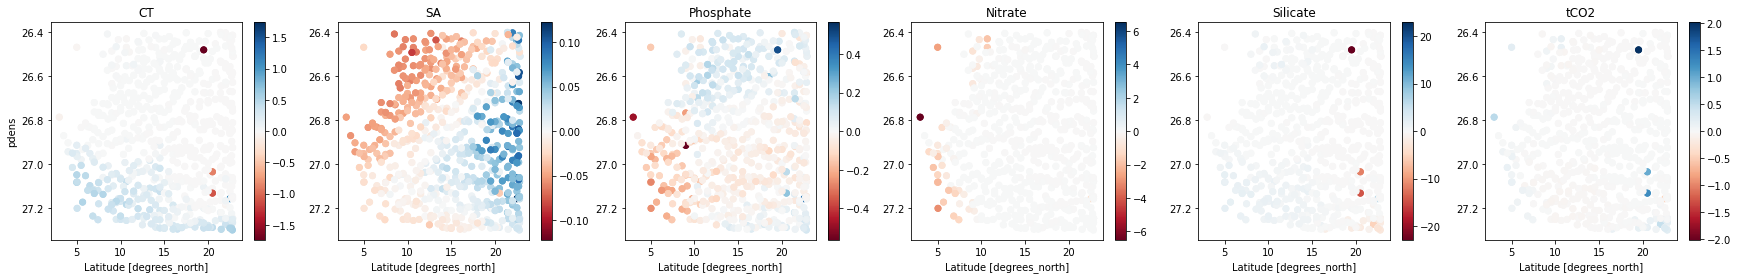

std


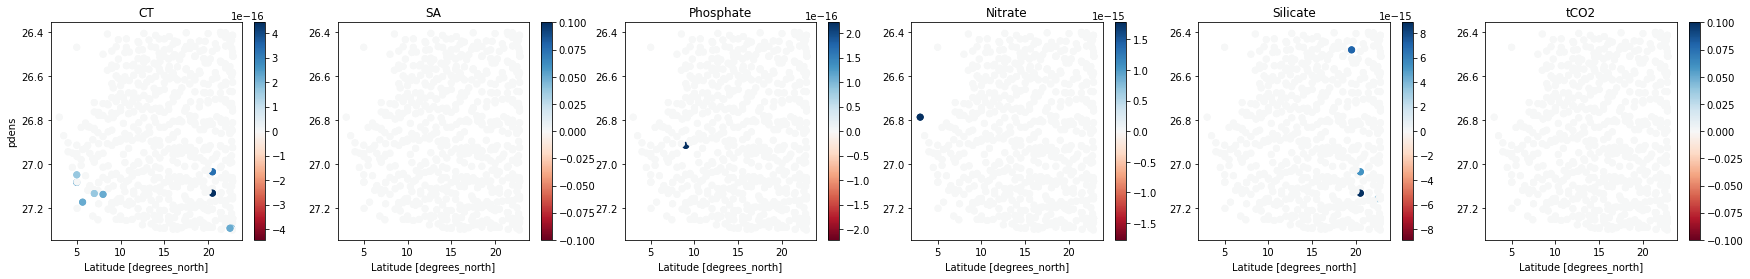

In [ ]:
print("mean")

def plot_ompasoln_residuals2(ompa_soln, xaxis_colname,
                             yaxis_colname, flip_y=True):
  pyompa.plotting.plot_residuals(
          param_residuals=ompa_soln.param_residuals,
          param_names=ompa_soln.param_names,
          xaxis_vals=ompa_soln.obs_df[xaxis_colname],
          xaxis_label=xaxis_colname,
          yaxis_vals=ompa_soln.obs_df[yaxis_colname],
          yaxis_label=yaxis_colname, flip_y=flip_y,
          perobs_weighted_resid_sq=None)

plot_ompasoln_residuals2(ompa_soln=mean_skeleton,
                                  xaxis_colname="Latitude [degrees_north]",
                                  yaxis_colname="pdens")
print("std")
plot_ompasoln_residuals2(ompa_soln=std_skeleton,
                                  xaxis_colname="Latitude [degrees_north]",
                                  yaxis_colname="pdens")

In [ ]:
###uncomment below to export csv with senstivity analysis info###

#ORIG_COLS_TO_INCLUDE = ORIG_COLS_TO_INCLUDE
#mean_skeleton.export_to_csv(
    #csv_output_name="mean_skeleton.csv",
    #orig_cols_to_include=ORIG_COLS_TO_INCLUDE)
#std_skeleton.export_to_csv(
    #csv_output_name="std_skeleton.csv",
    #orig_cols_to_include=ORIG_COLS_TO_INCLUDE)

In [9]:
#Install endmember sensitivities

!pip uninstall -y ETNP_stoich
%cd /content/
!rm -rf ETNP_stoich
!git clone https://github.com/NatalyaEvans/ETNP_stoich/
%cd /content/ETNP_stoich
!git checkout main
!git log -1
!pip install .
%cd /content/

%reload_ext autoreload
%autoreload 2
from importlib import reload
import pyompa_scripts
reload(pyompa_scripts)

/content
Cloning into 'pyompa_scripts'...
remote: Not Found
fatal: repository 'https://github.com/NatalyaEvans/ETNP_stoich/pyompa_scripts/' not found
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


ModuleNotFoundError: ignored

In [ ]:
def perturb_endmember_df(df, variation_range, rng):
  new_df = OrderedDict([
      ("Params", df["Params"]) #endmember name column
  ])
  params_to_perturb = ["CT", "SA", "Phosphate", "Nitrate", "Silicate", "tCO2"]
  for param_name in params_to_perturb:
    values = list(df[param_name])
    new_values = [rng.uniform(value-variation_range[param_name],
                              value+variation_range[param_name])
                  for value in values]
    new_df[param_name] = new_values

  return pd.DataFrame(new_df)


def perturb_endmember_df_stoichiometrically(df, stoichiometry, rng,
                                            perturbation_limits=(-1,1)):
  #in Talia's project, pertubation_limits corresponds to phosphate which
  # has ratio 1 wrt to the converted param
  
  new_df = OrderedDict([
      ("Params", df["Params"]), #endmember name column
      ("CT", df["CT"]),
      ("SA", df["SA"]),
  ])

  params_to_perturb = ["Phosphate", "Nitrate", "Silicate", "tCO2"]
  #sample a different perturbation for each row in the data frame
  sampled_perturbations = [rng.uniform(perturbation_limits[0],
                                       perturbation_limits[1])
                           for i in range(len(df))]
  print(sampled_perturbations)
  for param_name in params_to_perturb:
    values = list(df[param_name])
    new_values = [value + sampled_perturbation*stoichiometry[param_name]
                  for sampled_perturbation,value in
                  zip(sampled_perturbations,values)]
    new_df[param_name] = new_values

  return pd.DataFrame(new_df)

variation_range = {
    "CT": 3, "SA": 0.75, "Phosphate": 1.5, "Nitrate": 10,
    "Silicate": 20, "tCO2": 100
}

perturb_endmember_df_stoichiometrically(
    endmembers_df,
    stoichiometry=convertedparamgroups[0].conversion_ratios[1],
    perturbation_limits=(-0.5, 0.5),
    rng = np.random.RandomState(1234))

[-0.3084805496211077, 0.12210877103983186, -0.06227226099288552]


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.021519  24.745831   8.692934  2198.599295
1  NEPIW   9.47  34.78   2.772109  37.675849  39.721221  2284.408835
2   AAIW   5.53  34.70   3.067728  42.151372  80.690931  2315.651873

Sensitivity with regards to endmembers

In [ ]:
#Prepare the varying OMPA arguments

rng = np.random.RandomState(1234) #instantiate random number generator with fixed seed
num_samples = 20
base_endmembers = endmembers_df

#sample varying parameter weightings
sampled_endmembers = []
for i in range(num_samples):
    sampled_endmembers.append(perturb_endmember_df_stoichiometrically(
    endmembers_df,
    stoichiometry=convertedparamgroups[0].conversion_ratios[1],
    perturbation_limits=(-0.5, 0.5), rng=rng))
    print("Iteration:", i)
    display(sampled_endmembers[-1])

##write out the various sampled weightings
#open("sampled_endmembers.json", "w").write(
#    json.dumps(sampled_endmembers, indent=4))

varying_arguments_list = [OmpaArguments(
        constructor_arguments={},
        solve_arguments={"endmember_df": df}) for df in sampled_endmembers]

ETNP_weighting_sens_analysis = BaseSensitivityAnalysis(
    static_ompa_arguments = OmpaArguments(
        constructor_arguments={
          "param_weightings": paramweightings,
          "obs_df": ETNP_df_ompasoln.obs_df,
          "endmembername_to_usagepenaltyfunc": usage_penalty,
          "param_names": ETNP_df_ompasoln.param_names,
          "convertedparam_groups": convertedparamgroups
          },
        solve_arguments={
            "endmember_name_column": "Params",
            "batch_size": 100
        }
    ))

!mkdir endmembers_sensitivity
ompa_solns = ETNP_weighting_sens_analysis.run(
    varying_arguments_list = varying_arguments_list,
    outdir="endmembers_sensitivity",
    export_settings={"orig_cols_to_include":ORIG_COLS_TO_INCLUDE})

[-0.3084805496211077, 0.12210877103983186, -0.06227226099288552]
Iteration: 0


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.021519  24.745831   8.692934  2198.599295
1  NEPIW   9.47  34.78   2.772109  37.675849  39.721221  2284.408835
2   AAIW   5.53  34.70   3.067728  42.151372  80.690931  2315.651873

[0.2853585837137692, 0.2799758081188035, -0.22740739471735838]
Iteration: 1


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.615359  34.841096  37.197212  2268.672313
1  NEPIW   9.47  34.78   2.929976  40.359589  47.298839  2303.037145
2   AAIW   5.53  34.70   2.902593  39.344074  72.764445  2296.165927

[-0.2235357448569033, 0.30187217753501927, 0.4581393536837052]
Iteration: 2


Params     CT     SA  Phosphate    Nitrate    Silicate         tCO2
0   13CW  13.41  34.95   2.106464  26.189892   12.770284  2208.622782
1  NEPIW   9.47  34.78   2.951872  40.731827   48.349865  2305.620917
2   AAIW   5.53  34.70   3.588139  50.998369  105.670689  2377.060444

[0.3759326347420947, -0.14218273004213333, 0.0009951255234587064]
Iteration: 3


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.705933  36.380855  41.544766  2279.360051
1  NEPIW   9.47  34.78   2.507817  33.182894  27.035229  2253.222438
2   AAIW   5.53  34.70   3.130995  43.226917  83.727766  2323.117425

[0.1834629351721363, 0.2127020269829002, -0.12974924520960507]
Iteration: 4


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.513463  33.108870  32.306221  2256.648626
1  NEPIW   9.47  34.78   2.862702  39.215934  44.069697  2295.098839
2   AAIW   5.53  34.70   3.000251  41.004263  77.452036  2307.689589

[0.061196186065624936, 0.003083165307809721, -0.48623155040931776]
Iteration: 5


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.391196  31.030335  26.437417  2242.221150
1  NEPIW   9.47  34.78   2.653083  35.652414  34.007992  2270.363814
2   AAIW   5.53  34.70   2.643768  34.944064  60.340886  2265.624677

[0.27282662161237403, 0.38264119063611657, -0.13511401609862772]
Iteration: 6


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.602827  34.628053  36.595678  2267.193541
1  NEPIW   9.47  34.78   3.032641  42.104900  52.226777  2315.151660
2   AAIW   5.53  34.70   2.994886  40.913062  77.194527  2307.056546

[0.1153961784334937, -0.42461875835702345, -0.1311759939980255]
Iteration: 7


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.445396  31.951735  29.039017  2248.616749
1  NEPIW   9.47  34.78   2.225381  28.381481  13.478300  2219.894987
2   AAIW   5.53  34.70   2.998824  40.980008  77.383552  2307.521233

[0.4331401019825216, 0.1513781432265774, -0.1027974222738458]
Iteration: 8


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.763140  37.353382  44.290725  2286.110532
1  NEPIW   9.47  34.78   2.801378  38.173428  41.126151  2287.862621
2   AAIW   5.53  34.70   3.027203  41.462444  78.745724  2310.869904

[0.2887301429407455, -0.18316387783112875, 0.06809865262606918]
Iteration: 9


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.618730  34.898412  37.359047  2269.070157
1  NEPIW   9.47  34.78   2.466836  32.486214  25.068134  2248.386662
2   AAIW   5.53  34.70   3.198099  44.367677  86.948735  2331.035641

[0.3691273895612258, -0.06382657610432063, 0.3021476420801591]
Iteration: 10


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.699127  36.265166  41.218115  2278.557032
1  NEPIW   9.47  34.78   2.586173  34.514948  30.796324  2262.468464
2   AAIW   5.53  34.70   3.432148  48.346510  98.183087  2358.653422

[-0.3562331754854354, 0.2042609711183354, 0.20458130818957254]
Iteration: 11


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   1.973767  23.934036   6.400808  2192.964485
1  NEPIW   9.47  34.78   2.854261  39.072437  43.664527  2294.102795
2   AAIW   5.53  34.70   3.334581  46.687882  93.499903  2347.140594

[-0.2812078943259114, 0.42486762861556504, -0.05785924459582337]
Iteration: 12


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.048792  25.209466  10.002021  2201.817468
1  NEPIW   9.47  34.78   3.074868  42.822750  54.253646  2320.134380
2   AAIW   5.53  34.70   3.072141  42.226393  80.902756  2316.172609

[0.4093159589724725, -0.4401907772201481, -0.31571291618618635]
Iteration: 13


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.739316  36.948371  43.147166  2283.299283
1  NEPIW   9.47  34.78   2.209809  28.116757  12.730843  2218.057488
2   AAIW   5.53  34.70   2.814287  37.842880  68.525780  2285.745876

[-0.45264472119848487, 0.1748809435823302, 0.09462477993444884]
Iteration: 14


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   1.877355  22.295040   1.773053  2181.587923
1  NEPIW   9.47  34.78   2.824881  38.572976  42.254285  2290.635951
2   AAIW   5.53  34.70   3.224625  44.818621  88.221989  2334.165724

[0.03331016299875056, -0.4566759373051965, 0.06143308006339787]
Iteration: 15


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.363310  30.556273  25.098888  2238.930599
1  NEPIW   9.47  34.78   2.193324  27.836509  11.939555  2216.112239
2   AAIW   5.53  34.70   3.191433  44.254362  86.628788  2330.249103

[-0.17033155437908498, 0.002966833112618361, -0.3881056824255962]
Iteration: 16


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.159668  27.094364  15.324085  2214.900877
1  NEPIW   9.47  34.78   2.652967  35.650436  34.002408  2270.350086
2   AAIW   5.53  34.70   2.741894  36.612203  65.050927  2277.203529

[0.10719370621848456, 0.06594464305053138, -0.4932359380099972]
Iteration: 17


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.437194  31.812293  28.645298  2247.648857
1  NEPIW   9.47  34.78   2.715945  36.721059  37.025343  2277.781468
2   AAIW   5.53  34.70   2.636764  34.824989  60.004675  2264.798159

[0.11744170880429705, 0.4121228864331543, 0.2905241330570334]
Iteration: 18


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.447442  31.986509  29.137202  2248.858122
1  NEPIW   9.47  34.78   3.062123  42.606089  53.641899  2318.630501
2   AAIW   5.53  34.70   3.420524  48.148910  97.625158  2357.281848

[0.49208146618836146, 0.4588017621528665, 0.2919641352916398]
Iteration: 19


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.822081  38.355385  47.119910  2293.065613
1  NEPIW   9.47  34.78   3.108802  43.399630  55.882485  2324.138608
2   AAIW   5.53  34.70   3.421964  48.173390  97.694278  2357.451768

On varying argument 0 out of 20
varying arguments: OMPAArguments(constructor_arguments={}, solve_arguments={'endmember_df':   Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.021519  24.745831   8.692934  2198.599295
1  NEPIW   9.47  34.78   2.772109  37.675849  39.721221  2284.408835
2   AAIW   5.53  34.70   3.067728  42.151372  80.690931  2315.651873})
Adding penalty for AAIW
Endmember-idx mapping is
 OrderedDict([('13CW', [0]), ('NEPIW', [1]), ('AAIW', [2])])
params to use: ['CT', 'SA', 'Phosphate', 'Nitrate', 'Silicate', 'tCO2']
param weighting: [12.  8.  6.  4.  2.  4.]
Matrix A:
Trying convertedvariable sign constraint: [1 1 1 1]
On example 0 to 100 out of 1220
status: optimal
optimal value 5669.72387477887
Original weighted sum squares: 5669.684280140886
Post fix weighted sum squared: 5669.68428802449
On example 100 to 200 out of 1220
status: optimal
optimal value 915.406622229166
Original weighted sum squares: 915.3938634990787
Post 

In [ ]:
from gp15wma.sensitivity import get_mean_and_stdev_skeletons

mean_skeleton, std_skeleton = get_mean_and_stdev_skeletons(ompa_solns=ompa_solns)

mean


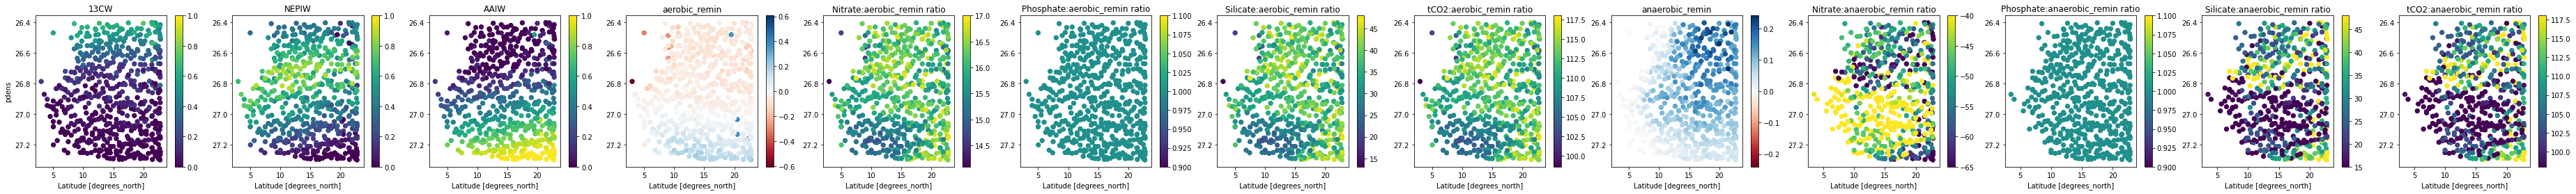

std


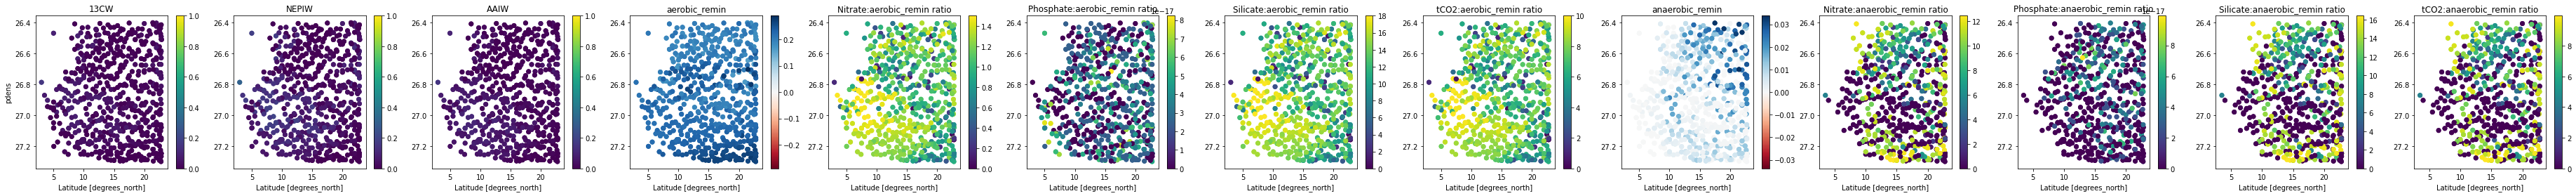

In [ ]:
#plot the solutions
print("mean")
pyompa.plot_ompasoln_endmember_fractions(ompa_soln=mean_skeleton,
                                  xaxis_colname="Latitude [degrees_north]",
                                  yaxis_colname="pdens")
print("std")
pyompa.plot_ompasoln_endmember_fractions(ompa_soln=std_skeleton,
                                  xaxis_colname="Latitude [degrees_north]",
                                  yaxis_colname="pdens")

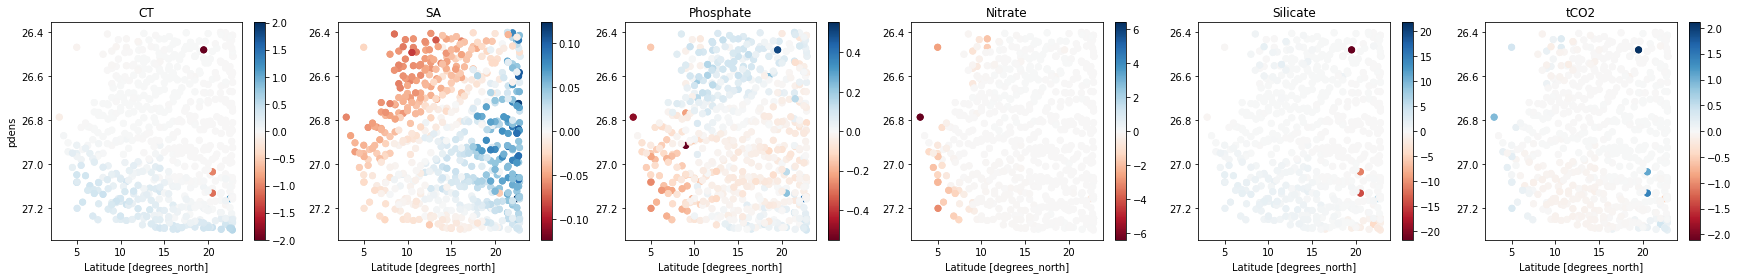

std


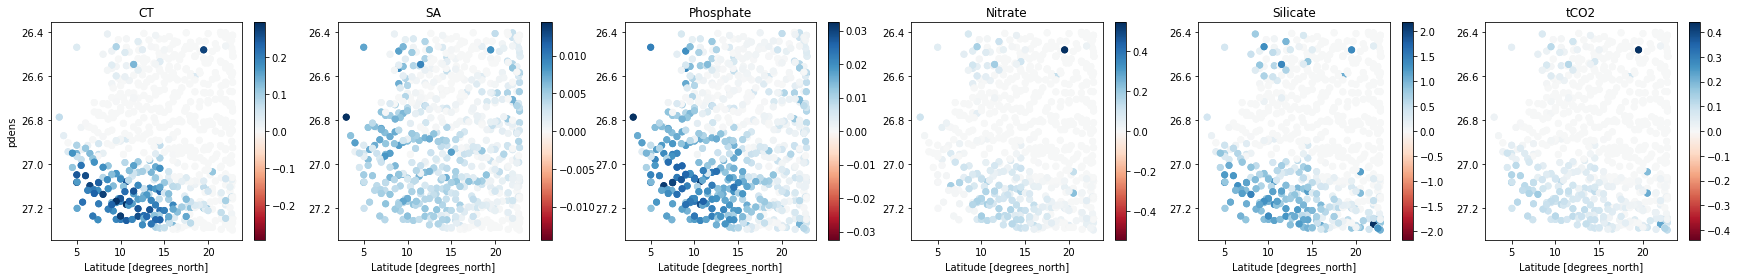

In [ ]:
plot_ompasoln_residuals2(ompa_soln=mean_skeleton,
                                  xaxis_colname="Latitude [degrees_north]",
                                  yaxis_colname="pdens")
print("std")
plot_ompasoln_residuals2(ompa_soln=std_skeleton,
                                  xaxis_colname="Latitude [degrees_north]",
                                  yaxis_colname="pdens")

In [ ]:
###uncomment below to export csv with senstivity analysis info###

#ORIG_COLS_TO_INCLUDE = ORIG_COLS_TO_INCLUDE
#mean_skeleton.export_to_csv(
    #csv_output_name="mean_skeleton.csv",
    #orig_cols_to_include=ORIG_COLS_TO_INCLUDE)
#std_skeleton.export_to_csv(
    #csv_output_name="std_skeleton.csv",
    #orig_cols_to_include=ORIG_COLS_TO_INCLUDE)